                           Spam Email Detection on imbalanced data
This kernel is about spam , non spam email detection.Each record is described with 58 attributes : attributes 1-57 represent various content-based characteristics already extracted from each email message (related to the frequency of certain words or certain punctuation symbols in a message as well as to the usage of capital letters in a message), and the last attribute represents the class label for each message (spam or non-spam).
Purpose :
Part A) : In model training phase we have to show how to handle imbalanced data
This we can show by two ways 
i) By upsamplibg/downsampling/SMOTE technique on data.
or ii)By creating a model considering class_weight hyper parameter .
Any of these techniques can handle imbalanced data in training period.(I have used SMOTE technique). 
Part B) : In model testing/performance evaluation phase - We have to show how to handle imbalanced data.
both ways - i) Using evaluation metrices in terms of accuracy, mcc, kappa , precion recall curve.
ii) Using cost evaluation model using weight of cost matrix as 10:1 .

In [1]:
import math
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score,confusion_matrix, accuracy_score,recall_score,ConfusionMatrixDisplay, \
precision_score,classification_report,f1_score,roc_curve, auc,roc_auc_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, precision_recall_curve
#from pingouin import multivariate_normality
from imblearn.over_sampling import SMOTE
#from sklearn import preprocessing
from sklearn import decomposition
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import discriminant_analysis
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold
from subprocess import check_call
from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set()

RAND_SEED = 5693

Data Loading

In [2]:
spam_data = pd.read_csv("spambase.data",header=None)

print("Dataset has", spam_data.shape[0], "observations and",
      spam_data.shape[1] - 1, "predictors")

Dataset has 4601 observations and 57 predictors


Data Exploration

In [3]:
spam_data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
new_column_names=['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 
    'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 
    'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 
    'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 
    'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 
    'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 
    'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 
    'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 
    'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 
    'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 
    'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capital_run_length_average', 
    'capital_run_length_longest', 'capital_run_length_total' ,'class']
spam_data.columns = new_column_names


In [5]:
spam_data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Feature engineering

In [6]:
#check null
count = 0
for i in spam_data.isnull().sum(axis=1):
    if i > 0:
        count = count + 1
print("Number of rows containing missing values is", count)

Number of rows containing missing values is 0


In [7]:
spam_data.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [8]:
spam_data['class'].value_counts()

0    2788
1    1813
Name: class, dtype: int64

Display the imbalanced proportion of data

<AxesSubplot:xlabel='class', ylabel='count'>

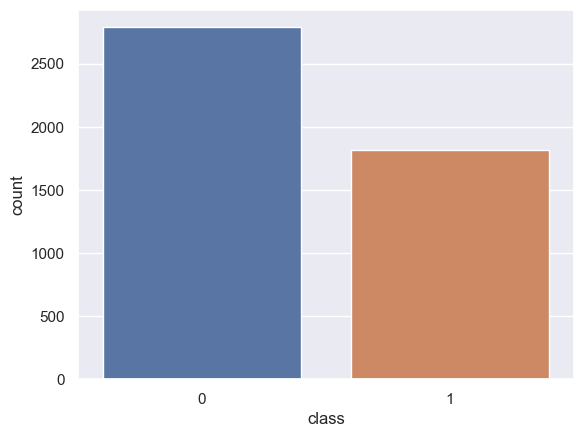

In [9]:
sns.countplot(x="class", data=spam_data)


# Part A) : In model training phase we have to show how to handle imbalanced data

In [10]:
#Fixing the imbalance using SMOTE Technique
spam_df = spam_data.copy()

print('Original class distribution:')
print(spam_df['class'].value_counts())

xf = spam_df.columns
X = spam_df.drop(['class'],axis=1)
y = spam_df['class']

smote = SMOTE()
X, y = smote.fit_resample(X, y)

spam_df = pd.DataFrame(X, columns=xf)
spam_df['class'] = y

print('\nClass distribution after applying SMOTE Technique:',)
print(y.value_counts())

Original class distribution:
0    2788
1    1813
Name: class, dtype: int64

Class distribution after applying SMOTE Technique:
1    2788
0    2788
Name: class, dtype: int64


Splitting the data into train and test datasets

In [11]:
# Split into training and validation sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [12]:
X_train.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
5546,0.000000,0.000000,0.964543,0.0,0.000000,0.000000,0.964543,0.000000,0.000000,0.000000,...,0.0,0.00000,0.292643,0.0,0.609830,0.000000,0.000000,2.840693,11,34
1168,0.340000,0.000000,0.690000,0.0,0.170000,0.510000,0.000000,0.510000,0.170000,0.170000,...,0.0,0.00000,0.170000,0.0,1.275000,0.141000,0.000000,5.598000,78,711
5553,0.243007,0.305748,0.672247,0.0,0.677009,0.243007,0.061746,0.243007,0.182255,2.952818,...,0.0,0.00000,0.068177,0.0,0.617825,0.019200,0.029248,4.708590,128,873
5322,0.085311,0.432171,0.618133,0.0,0.274371,0.210318,0.059392,0.000000,0.085311,0.329045,...,0.0,0.65253,0.035906,0.0,4.962001,1.116351,0.000000,5.157444,52,752
1741,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.430000,0.000000,0.000000,0.470000,...,0.0,0.00000,0.000000,0.0,0.694000,0.000000,0.000000,7.709000,164,239


In [13]:
y_train.head()

5546    1
1168    1
5553    1
5322    1
1741    1
Name: class, dtype: int64

Standardization-is a scaling method where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero, and the resultant distribution has a unit standard deviation.

In [14]:
#Standardization using Standard Scaler
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train) 
X_test = sc_x.transform(X_test)

# Model Selection 

In [15]:
#Cross Validation to select best model 
# Number of random trials
NUM_TRIALS = 1

# Set up possible values of parameters to optimize over Logistic Regression
lr_grid = {
'penalty' : ['l2'],
    'C' : [.01,0.1],
    'solver' : ['newton-cg'],
    "max_iter" : [10000]    
}

# Set up possible values of parameters to optimize over Decison Tree
dt_grid = {'max_depth' : [3,5]}

# Set up possible values of parameters to optimize over knn
knn_grid = {'n_neighbors': [3,5,7,9]}

# Set up possible values of parameters to optimize over SVM
svm_grid = {'C': [.01,.1],'gamma': [.01, .1],
             'kernel': ["rbf"]}

# Set up possible values of parameters to optimize over Random Forest 
rb_grid={ 
     "n_estimators":[500],
    'max_depth': [3,5],                  
          'min_samples_leaf': [4],           
          'min_samples_split' : [0.01]}   

# Set up possible values of parameters to optimize over GradientBoosting 
gb_grid={ 
    "n_estimators":[100],
    'max_depth': [3,5],
    "learning_rate":[0.1,.001]}

# Set up possible values of parameters to optimize over Extreme GradientBoosting 
xb_grid={ 
       'n_estimators': [100,500],
    'learning_rate': [0.1,.001],
    'booster': ['gbtree'],
'scale_pos_weight':[10]
}

# Set up possible values of parameters to optimize over Naive Bayes
nb_grid=[{'priors':[None],'var_smoothing':[1e-09]}]


# We will use a Linear Regression Classifier 
lr = LogisticRegression()
# We will use a decision tree Classifier 
dt = DecisionTreeClassifier()
# We will use a knn Classifier 
knn = neighbors.KNeighborsClassifier()
#We willl use a Support Vecor Machine classifier
svm=SVC()
#We willl use a RandomForest classifier
rb=RandomForestClassifier()
#We willl use a GradientBoosting classifier
gb=GradientBoostingClassifier()
#We willl use a XGBoosting classifier
xb=xgb.XGBClassifier()

#We willl use a NB classifier
nb=GaussianNB()


# Arrays to store scores
nested_lr_scores = np.zeros(NUM_TRIALS)
nested_dt_scores = np.zeros(NUM_TRIALS)
nested_knn_scores = np.zeros(NUM_TRIALS)
nested_svm_scores = np.zeros(NUM_TRIALS)
nested_rb_scores=np.zeros(NUM_TRIALS)
nested_gb_scores=np.zeros(NUM_TRIALS)
nested_xb_scores=np.zeros(NUM_TRIALS)
nested_nb_scores=np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    scoring='accuracy'
    
    # Non_nested parameter search and scoring for Logistic Regression
    lr_model = GridSearchCV(estimator=lr, param_grid=lr_grid, scoring = scoring ,cv=inner_cv)
    
    # Non_nested parameter search and scoring for Decision Tree
    dt_model = GridSearchCV(estimator=dt, param_grid=dt_grid,scoring = scoring, cv=inner_cv)
    
    # Non_nested parameter search and scoring for knn
    knn_model = GridSearchCV(estimator=knn, param_grid=knn_grid,scoring = scoring, cv=inner_cv)
    
    # Non_nested parameter search and scoring for SVR
    svm_model = GridSearchCV(estimator=svm, param_grid=svm_grid,scoring = scoring, cv=inner_cv)
        
    # Non_nested parameter search and scoring for RandomForestRegressor
    rb_model = GridSearchCV(estimator=rb, param_grid=rb_grid,scoring = scoring, cv=inner_cv)
    # Non_nested parameter search and scoring for GradientBoostingRegressor
    gb_model = GridSearchCV(estimator=gb, param_grid=gb_grid,scoring = scoring, cv=inner_cv)
    # Non_nested parameter search and scoring for XGBoostRegressor
    xb_model = GridSearchCV(estimator=xb, param_grid=xb_grid,scoring = scoring, cv=inner_cv)
    
    # Non_nested parameter search and scoring for Naive Baes
    nb_model = GridSearchCV(estimator=nb, param_grid=nb_grid, cv=inner_cv)    
    
    # Nested CV with parameter optimization for Logistic Regression
    nested_lr_score = cross_val_score(lr_model, X=X_train, y=y_train, cv=outer_cv)
    nested_lr_scores[i] = nested_lr_score.mean()

    # Nested CV with parameter optimization for Decision Tree
    nested_dt_score = cross_val_score(dt_model, X=X_train, y=y_train, cv=outer_cv)
    nested_dt_scores[i] = nested_dt_score.mean()
    
    # Nested CV with parameter optimization for knn
    nested_knn_score = cross_val_score(knn_model, X=X_train, y=y_train, cv=outer_cv)
    nested_knn_scores[i] = nested_knn_score.mean()
    
    # Nested CV with parameter optimization for svm
    nested_svm_score = cross_val_score(svm_model, X=X_train, y=y_train, cv=outer_cv)
    nested_svm_scores[i] = nested_svm_score.mean()
    
    # Nested CV with parameter optimization for RandomForestRegressor
    nested_rb_score = cross_val_score(rb_model, X=X_train, y=y_train, cv=outer_cv)
    nested_rb_scores[i] = nested_rb_score.mean()    
    
    # Nested CV with parameter optimization for  GradientBoostingRegressor
    nested_gb_score = cross_val_score(gb_model, X=X_train, y=y_train, cv=outer_cv)
    nested_gb_scores[i] = nested_gb_score.mean()    
    
    # Nested CV with parameter optimization for  XGBoostingRegressor
    nested_xb_score = cross_val_score(xb_model, X=X_train, y=y_train, cv=outer_cv)
    nested_xb_scores[i] = nested_xb_score.mean()  

    # Nested CV with parameter optimization for Naive Bayes
    nested_nb_score = cross_val_score(nb_model, X=X_train, y=y_train, cv=outer_cv)
    nested_nb_scores[i] = nested_nb_score.mean()      


#Print the mean score using nested cross-validation
models = ['Logistic regression','Decision tree','KNN','SVM','RandomForest','GradientBoosting','XGBoost','Naive Baes']
df_scores_ALL = pd.DataFrame(
{'Model': models,
 'Scores trial': [nested_lr_scores[0],nested_dt_scores[0],nested_knn_scores[0], \
                  nested_svm_scores[0],nested_rb_scores[0],nested_gb_scores[0],nested_xb_scores[0], \
                  nested_nb_scores[0]]
})




In [16]:
# Sort in descending order (larger the better )
print('Nested Cross Validation scores with Hyper Parameter tuning after trial')
df_scores_ALL_sorted = df_scores_ALL.sort_values(by='Scores trial', ascending=False)
df_scores_ALL_sorted.head(10)

Nested Cross Validation scores with Hyper Parameter tuning after trial


,Model,Scores trial
6,XGBoost,0.961435
5,GradientBoosting,0.956278
4,RandomForest,0.935426
0,Logistic regression,0.930942
2,KNN,0.918610
3,SVM,0.914574
1,Decision tree,0.910762
7,Naive Baes,0.852691


Best Model is XGBoost as it shows the highest score after cross-validation.

# Part B: Task 1 - Performance evaluation using metrices.

In [17]:
#This is a function to display Confusion Matrix
def DisplayConfusionMatrix(_y_pred, _title):
    # Compute confusion matrix
    matrix = confusion_matrix(y_test, _y_pred)
      # Build the plot
    plt.figure(figsize=(7,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True,fmt='d', annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)
    # Add labels to the plot
    class_names = ['Spam','Non-Spam']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(_title)
    plt.show()

Priniting metrices for BEST MODEL for scenario A without cost sensitive learning :XGBoost
 accuracy score: 0.9480
Confusion Matrix: 
 [[521  37]
 [ 21 537]]


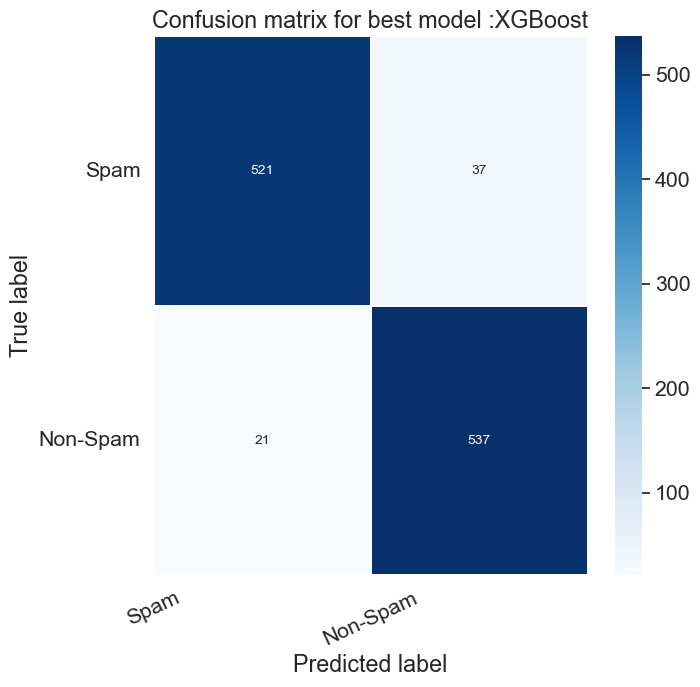

In [18]:
#best_classifier = XGBoost
xb_model.fit(X_train,y_train)
y_pred=xb_model.predict(X_test)
print('Priniting metrices for BEST MODEL for scenario A without cost sensitive learning :XGBoost') 
print(' accuracy score: {0:0.4f}'. format(xb_model.score(X_test,y_test)))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
DisplayConfusionMatrix(y_pred,"Confusion matrix for best model :XGBoost")

In [19]:
#Performance measures
print('Accuracy of logistic regression classifier on test set: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))
print('Precision of logistic regression classifier on test set: {:.2f}%'.format(precision_score(y_test, y_pred)*100))
print('Recall of logistic regression classifier on test set: {:.2f}%'.format(recall_score(y_test, y_pred)*100))
print('F1 Score of logistic regression classifier on test set: {:.2f}%'.format(f1_score(y_test, y_pred)*100))
print('Classification Report is : ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 94.80%
Precision of logistic regression classifier on test set: 93.55%
Recall of logistic regression classifier on test set: 96.24%
F1 Score of logistic regression classifier on test set: 94.88%
Classification Report is : 
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       558
           1       0.94      0.96      0.95       558

    accuracy                           0.95      1116
   macro avg       0.95      0.95      0.95      1116
weighted avg       0.95      0.95      0.95      1116



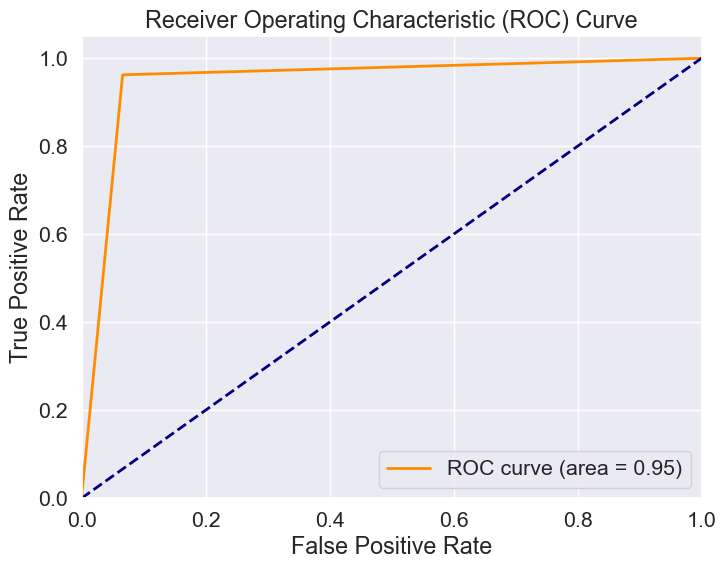

In [20]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

As the data set was imbalanced , accuracy may not be a good measure of performance evaluation.So we use MCC/Kappa/Precision Recall curve to evaluate the performance of the model.

Matthews Correlation Coefficient: 0.90
Cohen's Kappa: 0.90


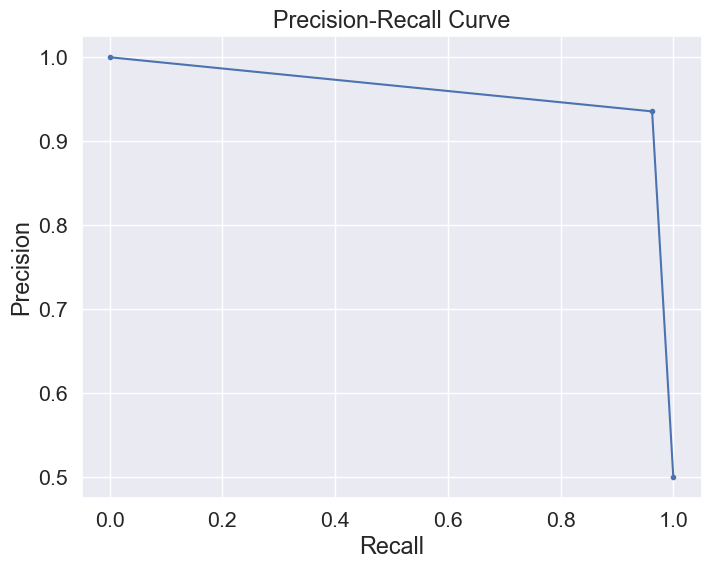

In [21]:
#Performance using MCC,Kappa and Precisuon recall curve.
# Calculate MCC
mcc = matthews_corrcoef(y_test, y_pred)
print('Matthews Correlation Coefficient: {:.2f}'.format(mcc))

# Calculate Cohen's kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohen\'s Kappa: {:.2f}'.format(kappa))

# Generate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


MCC score should lie between -1 and +1 so our MCC score(.90) is pretty good.Also Kappa coefficient which compare accuracy of the classifier with the random accuracy of the system is also good(0.9) as its best value lies between 0 to 1.

# Part B: Task 2 - Cost-evaluation model using cost matrix.

Optimal Threshold: 0.9500000000000001
Minimum Cost: 201.0
Cost list [5580.  839.  701.  614.  547.  499.  459.  439.  420.  391.  391.  383.
  386.  368.  358.  338.  290.  298.  268.  201.  558.]


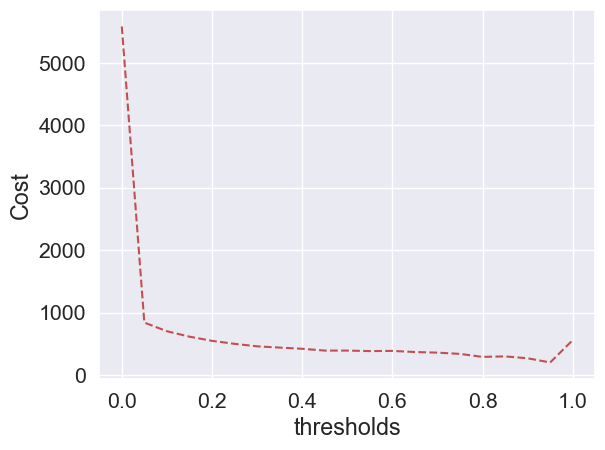

In [22]:
#Task2 :Cost Sensitive model FP cost = 10 , FN cost = 1 .Cost matrix ratio given as 10:1

# Now you can get the prediction probability for each example in the test set and setting the threshold for predictions
predict_probabilities = xb_model.predict_proba(X_test)[:,1] ##get prediction probability of label 1 
thresholds = np.linspace(0, 1.0, num=21)
Cost_List=np.linspace(0, 1.0, num=21)
#input cost matrix
cost_matrix = np.array([[0, 10], [1, 0]])
index=0

for t in thresholds:
    predict_thre = np.where(predict_probabilities > t, 1, 0)  ##prediction based on the preset threshold
    clf_matrix = confusion_matrix(y_test, predict_thre)
    Cost_List[index] = clf_matrix[0][0]*cost_matrix[0][0]+clf_matrix[0][1]*cost_matrix[0][1]+clf_matrix[1][0]*cost_matrix[1][0]+clf_matrix[1][1]*cost_matrix[1][1] ##note this only applies to binary classification
    index+=1
    
    
# Finding the minimum cost and the corresponding index
min_cost_index = np.argmin(Cost_List)
optimal_threshold = thresholds[min_cost_index]
min_cost = Cost_List[min_cost_index]

# Print the optimal threshold and minimum cost
print("Optimal Threshold:", optimal_threshold)
print("Minimum Cost:", min_cost)

print('Cost list',Cost_List) 
plt.figure(1)
plt.plot(thresholds, Cost_List, 'r--')
plt.xlabel("thresholds")
plt.ylabel("Cost")
plt.show()

In this case for the performance evaluation of imbalanced dataset using cost-evaluation method,the cost matrix is associatesd with the weight/cost matrix(10:1).
False negative - Identifying an email as Non-spam where actually it is a Spam email.
False positive - Identifying an email as Spam where actually it is a Non-Spam email.
As in spam email detection, the cost associated with false positive is considered more significant/costly than that of false negatives.Based on the importance of misclassification error, we have assigned FP cost : FN cost as 10:1 raio.
For every single  threshold we calculate the cost associated with the model.
It appears that the optimal threshold we obtained is 0.95, and the corresponding minimum cost is 201.0. These results imply that when using a threshold of 0.95, the model achieves the lowest cost of 201.0 based on your defined cost matrix and the associated predictions.